In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent
from utils.DummyAgent import DummyAgent
from utils.ChaoticAgent import ChaoticAgent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set constant hyperparameters
n_learner = 5
n_chaotic = 20
n_dummy = 5
n_simple = n_chaotic + n_dummy
n = n_learner+n_simple

num_of_tasks  = 8
num_of_sims = 5
step_limit = 20000

In [4]:
lower_bound = 0
upper_bound = 2.00
comm_array = np.linspace(lower_bound, upper_bound, 21)

comm_space = len(comm_array)

In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)
alr = 3e-4
vlr = 6e-4
ecoef = 0.08

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit))
comm_rec_actions = np.zeros((num_of_sims, step_limit, env.n))
move_rec_actions = np.zeros((num_of_sims, step_limit, env.n))
rec_rewards = np.zeros((num_of_sims, step_limit, env.n))

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        # reset the environment
        agentlist_learner = {i: Agent(alr=alr, vlr=vlr, ecoef=ecoef, num_arms=comm_space) for i in range(n_learner)}
        agentlist_simple = {j: DummyAgent(num_arms=comm_space) for j in range(n_dummy)}
        # Add ChaoticAgents to the dictionary
        agentlist_simple.update({j + n_dummy: ChaoticAgent(num_arms=comm_space) for j in range(n_chaotic)})
        print(agentlist_simple)

        observations = env.reset(n=n, num_of_tasks =num_of_tasks)

        # begin training loop

        t = 0
        while t < step_limit:
            print(t, end='\r')

            # collect move action for each agent
            move_action_learner = np.array([agentlist_learner[i].choose_action_move(observations[i]) for i in range(n_learner)])
            move_action_simple = np.array([agentlist_simple[j].choose_action_move() for j in range(n_simple)])
            move_action = np.concatenate((move_action_learner, move_action_simple))

            # env step 1
            next_observations, context = env.step1(move_action)

            # collect comm action for each agent
            comm_action_ind_learner = np.array([agentlist_learner[i].select_arm() for i in range(n_learner)])
            comm_action_ind_simple = np.array([agentlist_simple[j].select_arm() for j in range(n_simple)])
            comm_action_ind = np.concatenate((comm_action_ind_learner, comm_action_ind_simple))
            comm_action = comm_array[comm_action_ind]

            # env step 2
            rewards = env.step2(comm_action) # env.step

            # record stats
            comm_rec_actions[s, t, :] = comm_action  # output from actor (comm head)
            move_rec_actions[s, t, :] = move_action

            # update learning agents
            for i in range(n_learner): # train each agent
                action = np.array([move_action[i], comm_action_ind[i]])
                agentlist_learner[i].train(observations[i], action[0], rewards[i], next_observations[i])
                agentlist_learner[i].update_comm(action[1], rewards[i])

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t] = sum(rewards)/env.n
            rec_rewards[s, t, :] = rewards


            # increment timestep and loop
            t +=1


In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------
{0: <utils.DummyAgent.DummyAgent object at 0x00000237CAF00910>, 1: <utils.DummyAgent.DummyAgent object at 0x00000237CAF038B0>, 2: <utils.DummyAgent.DummyAgent object at 0x00000237CAF039A0>, 3: <utils.DummyAgent.DummyAgent object at 0x00000237CAF03A30>, 4: <utils.DummyAgent.DummyAgent object at 0x00000237CAF03A90>, 5: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03B50>, 6: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03C10>, 7: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03C70>, 8: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03CD0>, 9: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03D30>, 10: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03D90>, 11: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03DF0>, 12: <utils.ChaoticAgent.ChaoticAgent object at 0x00000237CAF03E50>, 13: <utils.ChaoticAgent.ChaoticAgent object

In [9]:
# save reward and actions
converged_structure = np.zeros((num_of_tasks, env.n))
task = 0
for C in env.CS:
    indices = [int(a)-1 for a in list(C)]
    converged_structure[task, indices] = 1
    task+=1

np.save(f'nl{n_learner}ns{n_simple}t{num_of_tasks}_cum_rew', steps_to_complete)
np.save(f'nl{n_learner}ns{n_simple}t{num_of_tasks}_rewards', rec_rewards)
np.save(f'nl{n_learner}ns{n_simple}t{num_of_tasks}_actions', comm_rec_actions)
np.save(f'nl{n_learner}ns{n_simple}t{num_of_tasks}_cstruct.npy', converged_structure)

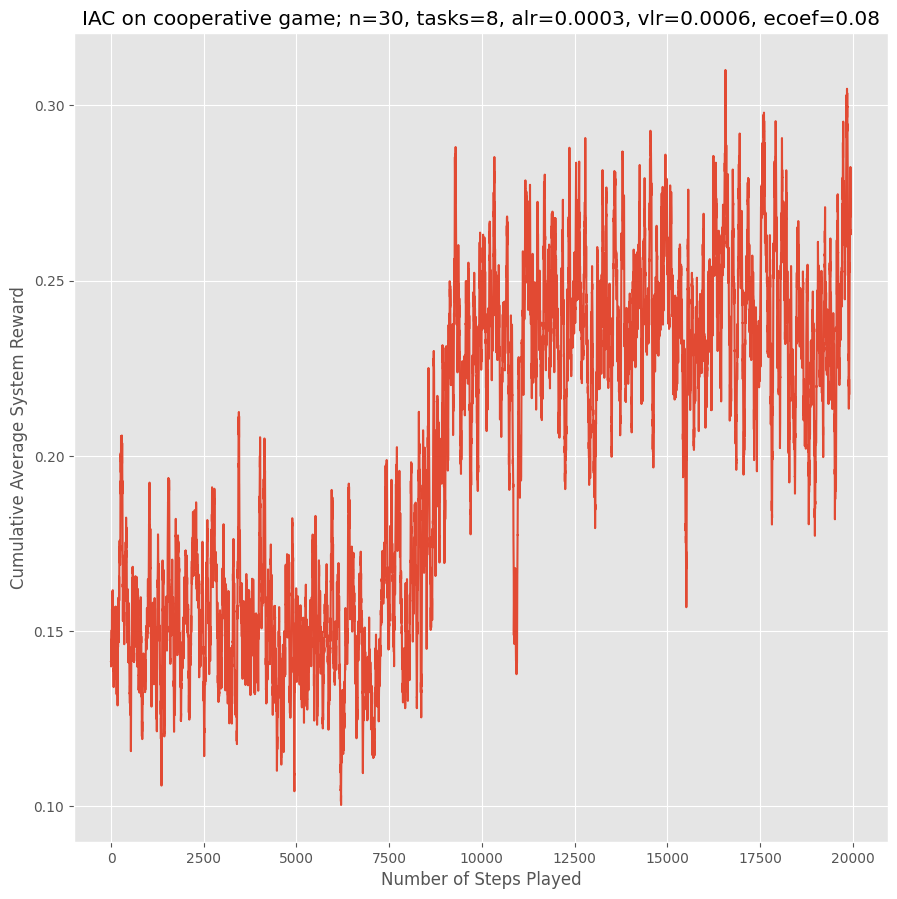

In [10]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)

def moving_average(arr, window_size):
    moving_averages = []
    for i in range(len(arr) - window_size + 1):
        window = arr[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return moving_averages

plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}, alr={alr}, vlr={vlr}, ecoef={ecoef}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(moving_average(b,50))

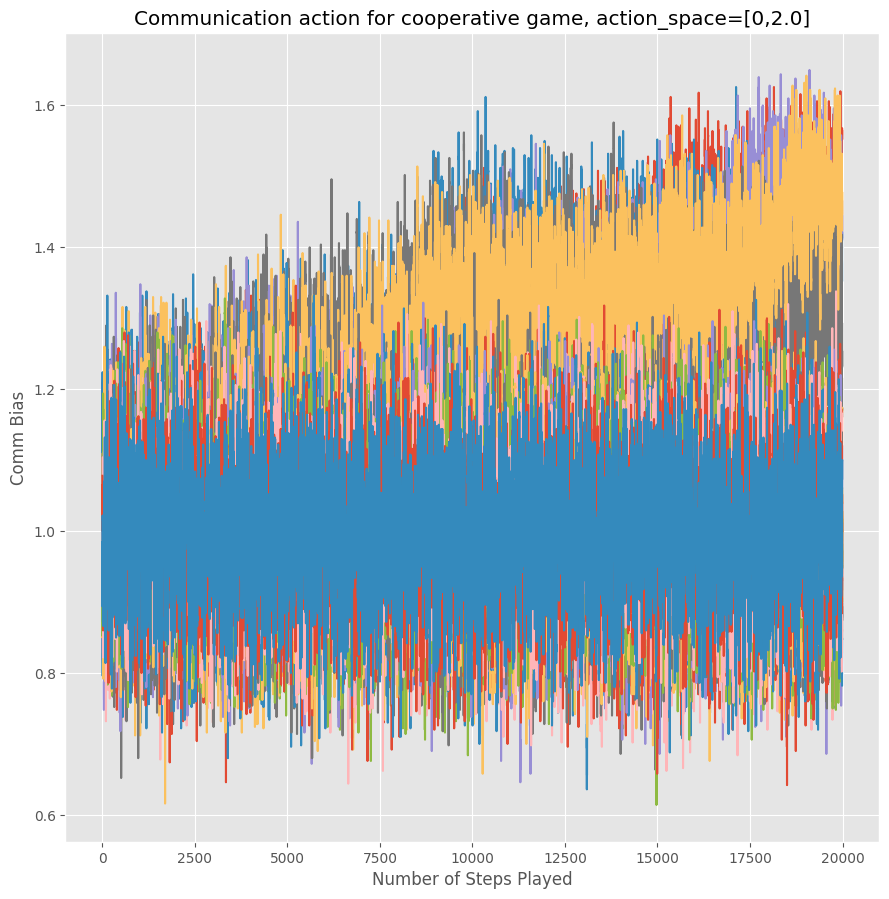

In [11]:
# See communication action averaged across sims

plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}]')

for j in range(n):
    col  = np.mean(comm_rec_actions[:,:,j],axis=0)
    plt.plot(moving_average(col, 10))

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

[{'14', '4', '20', '30'}, {'16', '27', '13', '12'}, {'26', '6', '8', '1', '11', '5', '2', '15'}, {'24', '3', '10'}, {'9'}, {'29', '21', '22'}, {'25', '19', '17', '28', '23'}, {'7', '18'}]


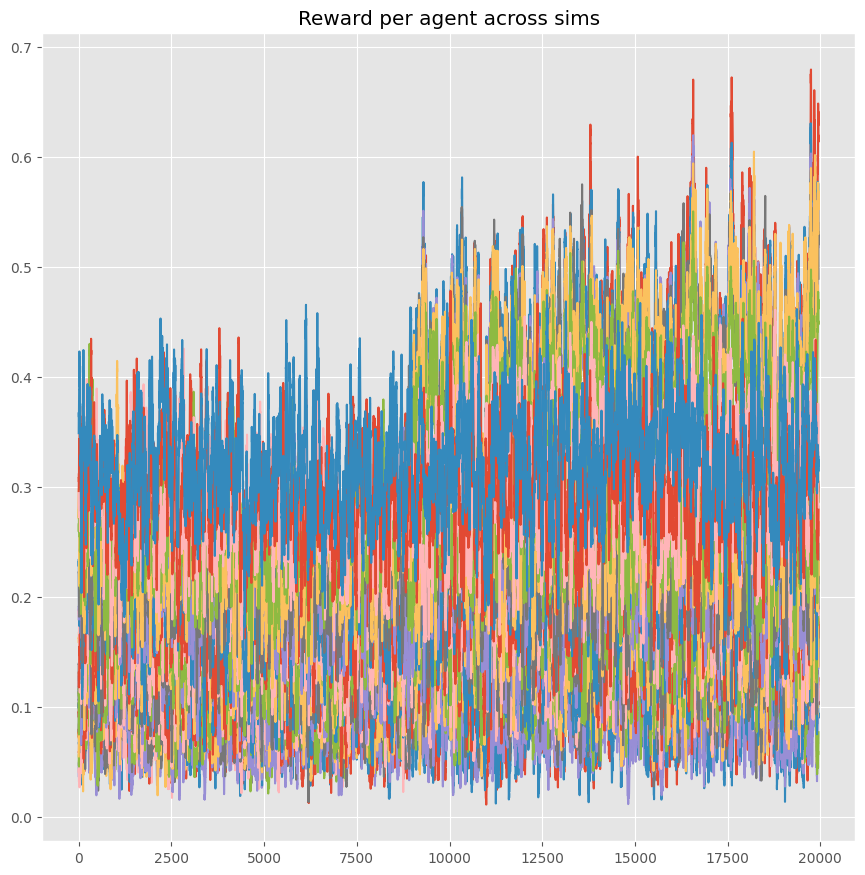

In [12]:
# see agent reward breakdown across sims

print(env.CS)
for j in range(env.n):
    col  = np.mean(rec_rewards[:,:,j],axis=0)
    plt.plot(moving_average(col, 50))

fig = plt.gcf()
plt.title('Reward per agent across sims')
fig.set_size_inches(10.5, 10.5)

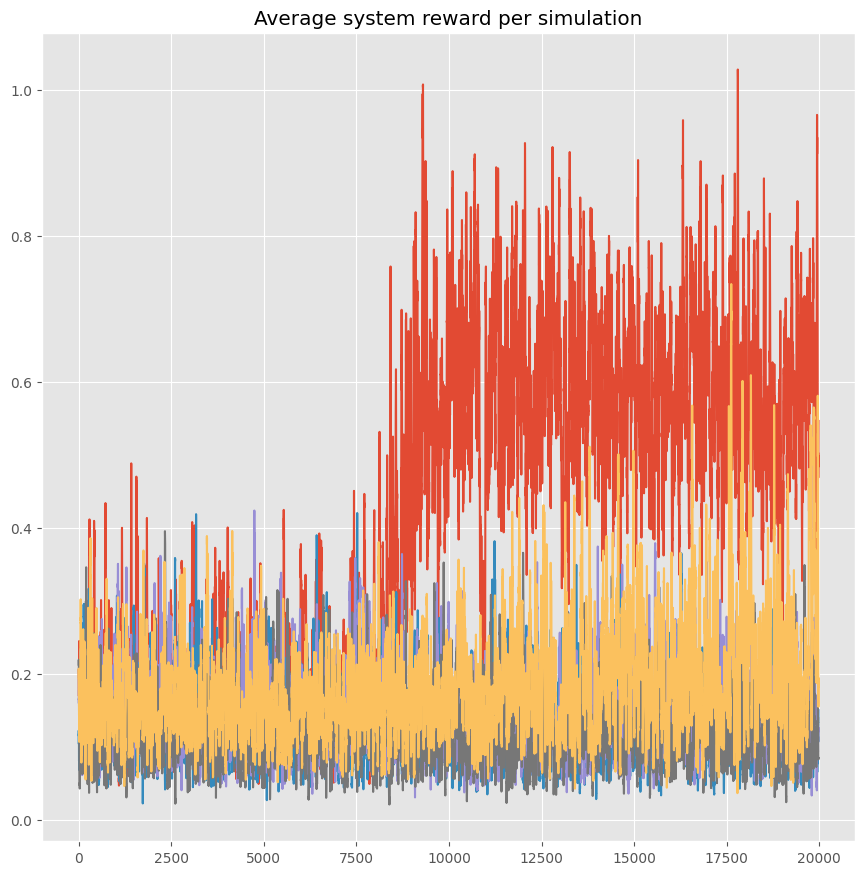

In [13]:
# See average reward breakdown for each sim

for i in range(num_of_sims):
    plt.plot(moving_average(steps_to_complete[i,:],20))

plt.title('Average system reward per simulation')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)